In [14]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from wbfm.utils.feature_detection.class_frame_pair import FramePair
from skimage import transform


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fname = "/home/charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True)

Output files: /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/global2tracklet_manual.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/manually_split_tracklets.h5, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_names.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



# Define a local coordinate system that points towards the centroid of the point cloud

In [6]:
pts = project_data.get_centroids_as_numpy(0)

In [7]:
centroid = np.median(pts, axis=0)

In [52]:
i = 10

anchor_pt = pts[i]
anchor_centroid_vec = anchor_pt - centroid

In [53]:
transform.matrix_transform(centroid[1:], matrix.params)

array([[160.19418781, 445.52656305]])

Text(0.5, 1.0, 'Original coordinate system')

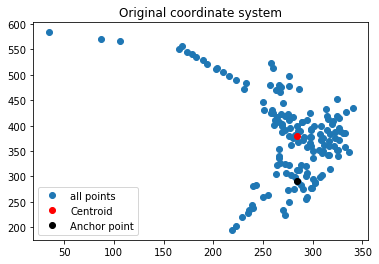

In [54]:
plt.plot(pts[:, 1], pts[:, 2], 'o', label="all points")
plt.plot(centroid[1], centroid[2], 'ro', label="Centroid")
plt.plot(anchor_pt[1], anchor_pt[2], 'ko', label="Anchor point")
plt.legend()
plt.title("Original coordinate system")

In [55]:
angle = np.arctan2(anchor_centroid_vec[1], anchor_centroid_vec[2])

In [56]:
matrix = transform.EuclideanTransform(rotation=angle)
matrix.params

array([[-1.0000000e+00, -1.2246468e-16,  0.0000000e+00],
       [ 1.2246468e-16, -1.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

Text(0.5, 1.0, 'Rotated to align to the centroid')

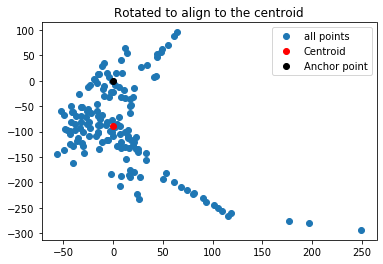

In [57]:
pts_transformed = transform.matrix_transform(pts[:, 1:] - anchor_pt[1:], matrix.params)
centroid_transformed = transform.matrix_transform(centroid[1:] - anchor_pt[1:], matrix.params)
anchor_transformed = transform.matrix_transform(anchor_pt[1:] - anchor_pt[1:], matrix.params)

plt.plot(pts_transformed[:, 0], pts_transformed[:, 1], 'o', label="all points")
plt.plot(centroid_transformed[:, 0], centroid_transformed[:, 1], 'ro', label="Centroid")
plt.plot(anchor_transformed[:, 0], anchor_transformed[:, 1], 'ko', label="Anchor point")
plt.legend()
plt.title("Rotated to align to the centroid")

In [34]:
centroid_transformed

array([[160.19418781, 445.52656305]])

# Make functions for transforming these coordinates

In [91]:
from dataclasses import dataclass
from sklearn.neighbors import NearestNeighbors


@dataclass
class PointCloudWithCentroid:
    
    pts: np.ndarray
    centroid: np.ndarray = None
    
    neighbor_obj: NearestNeighbors = None
    
    def __post_init__(self):
        self.centroid = np.median(self.pts, axis=0)
        # Note: the neighbors stay the same even if the coordinate system is rotated
        self.neighbor_obj = NearestNeighbors(n_neighbors=3).fit(self.pts[:, 1:])
        
    def get_anchor_pt(self, i):
        return self.pts[i]
        
    def get_transformation_to_centroid_coordinates(self, i):
        anchor_centroid_vec = self.get_anchor_pt(i) - self.centroid
        angle = np.arctan2(anchor_centroid_vec[1], anchor_centroid_vec[2])
        matrix = transform.EuclideanTransform(rotation=angle)
        
    def get_neighbors_in_local_coordinate_system(self, i, n_neighbors):
        
        matrix = self.get_transformation_to_centroid_coordinates(i)
        
        anchor_pt = self.get_anchor_pt(i)
        neighbor_dist, neighbor_ind = self.neighbor_obj.kneighbors(anchor_pt[1:].reshape(1, -1), n_neighbors + 1)
        # Closest neighbor is itself
        neighbor_dist = neighbor_dist[1:]
        neighbor_ind = neighbor_ind[1:]
        neighbors_zxy = self.pts[neighbor_ind, :]
        
        neighbors_transformed = transform.matrix_transform(neighbors_zxy[:, 1:] - anchor_pt[1:], matrix.params)
        
        print(neighbors_transformed)


In [92]:
cloud = PointCloudWithCentroid(pts)

In [93]:
neighbor_dist, neighbor_ind = cloud.neighbor_obj.kneighbors(anchor_pt[1:].reshape(1, -1), 5)

In [94]:
cloud.pts[neighbor_ind, :]

array([[[  5.73987641, 283.90766994, 290.36103235],
        [ 23.36665192, 285.11402034, 289.91862008],
        [  8.59126199, 282.2522454 , 297.99764043],
        [  9.66641871, 288.21398752, 283.6631245 ],
        [ 23.70796149, 278.37343358, 303.11676387]]])

In [95]:
cloud.get_neighbors_in_local_coordinate_system(0, 5)

ValueError: operands could not be broadcast together with shapes (0,5,3) (2,) 

In [62]:
%debug

> /home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/sklearn/utils/validation.py(698)check_array()
    696                     "Reshape your data either using array.reshape(-1, 1) if "
    697                     "your data has a single feature or array.reshape(1, -1) "
--> 698                     "if it contains a single sample.".format(array))
    699 
    700         # make sure we actually converted to numeric:



ipdb>  u


> /home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/sklearn/utils/validation.py(63)inner_f()
     61             extra_args = len(args) - len(all_args)
     62             if extra_args <= 0:
---> 63                 return f(*args, **kwargs)
     64 
     65             # extra_args > 0



ipdb>  q
